In [23]:
from gimpformats.gimpXcfDocument import GimpDocument
import cv2
import numpy as np


In [59]:
def imageListFromXcf(fileName):
    """ Give a the name of an xcf file, read it using GimpDocument
        extract and return a list of images along with a list of layer names, return it as two lists
    """

    """List data on groups followed by the direct children of a gimp xcf document
    """
    project = GimpDocument(fileName)

    layers = project.layers
    index = 0
    #print("## Group info...")
    #while index < len(layers):
    #    layerOrGroup = layers[index]
    #    if layerOrGroup.isGroup:
    #        index += 1
    #        while layers[index].itemPath is not None:
    #            #print("Group \"" + layerOrGroup.name + "\" contains Layer \"" + layers[index].name + "\"")
    #            layers.pop(index)
    #    else:
    #        index += 1

    #print("## Document direct children...")
    #images = []
    #for layerOrGroup in layers:
    #    print("\"" + layerOrGroup.name + "\" is a " + ("Group" if layerOrGroup.isGroup else "Layer"))
    #    images.append(layerOrGroup.image)
        #layerOrGroup.image.save(layerOrGroup.name+"amb.png")
    return zip(*[(l.name,l.image) for l in layers if not l.isGroup ][:-1])# CAREFUL!
    # Taking out the last one as it contains the full image!!!!!
   

    
def imageToPoints(image):
    
    # binarize image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray[gray > 0] = 255  

    #compute connected components
    numLabels, labelImage,stats, centroids = cv2.connectedComponentsWithStats(gray)
    
    #print("returning "+str(centroids[1:]))
    #plt.imshow(image)
   
    return centroids[1:] #eliminate background centroid
    

def readAnnotationFile(fileName):
    """ Give a the name of an xcf file, read it using GimpDocument
        First extract a list of images, 
        Then extract from each image the landmark points
        return the name of each layer along with the list of points
    """

    
    names,images = imageListFromXcf(fileName)
    points = [imageToPoints(np.array(x)) for x in images]
    
    return names,images,points
    
        
        

('linia mitja', 'astes anteriors', 'silvio', 'cerebel #1', 'c3', 'cerebel', 'talems', 'calota', 'Córtex')
2
2
3
4
0
8
4
4
3


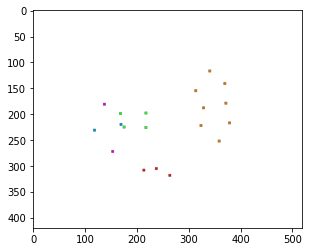

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

names,images,points = readAnnotationFile("Clandmarks.xcf")

print(names)
for x in points:
    print(len(x))

plt.imshow(images[0])
plt.imshow(images[1])
plt.imshow(images[2])
plt.imshow(images[3])
plt.imshow(images[4])
plt.imshow(images[5])

rows = 2

#for num, im in enumerate(images):
#    img = im
#    plt.subplot(rows,6,num+1)
#    plt.title(str(num))
#    plt.axis('off')
#    plt.imshow(img)